<a href="https://colab.research.google.com/github/sidhu2690/HMC/blob/main/HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bayesian linear regression model using Hamiltonian Monte Carlo sampling



In [38]:
import numpy as np
import numpy.linalg as la
import scipy.stats as stats

class BayesianLinearRegression:
    def __init__(self, X, y):
        self.X = np.hstack((np.ones((X.shape[0], 1)), X))                       # Add intercept term
        self.y = y
        self.n, self.d = self.X.shape
        self.beta = np.zeros(self.d)                                            # Initialize beta
        self.epsilon = 0.01                                                     # Initial step size
        self.target_acceptance_rate = 0.65                                      # Target acceptance rate
        self.mu = np.zeros(self.d)                                              # Initialize momentum mean
        self.M = np.eye(self.d)                                                 # Initialize momentum covariance
        self.step_size_adaptation_factor = 0.01                                 # Adaptation factor for step size
        self.hbar = 0                                                           # Initialize step size adaptation parameter
        self.log_bar = 0                                                        # Initialize log acceptance rate adaptation parameter
        self.gamma = 0.05                                                       # Adaptation rate for momentum distribution
        self.t0 = 10                                                            # Initial adaptation step for momentum distribution
        self.kappa = 0.75                                                       # Adaptation rate for step size
        self.delta = 0.6                                                        # Adaptation parameter for step size
        self.eta = 0.05                                                         # Adaptation parameter for step size
        self.epsilon_min = 0.001                                                # Minimum step size
        self.epsilon_max = 0.2                                                  # Maximum step size
        self.epsilon_update_factor = 0.01                                       # Update factor for step size
        self.M_inv = np.eye(self.d)

    def log_prior(self, beta):
        return stats.norm.logpdf(beta, loc=0, scale=10).sum()                   # Gaussian prior on beta

    def log_likelihood(self, beta):
        mu = np.dot(self.X, beta)
        return stats.norm.logpdf(self.y, loc=mu, scale=1).sum()                 # Gaussian likelihood

    def log_posterior(self, beta):
        return self.log_prior(beta) + self.log_likelihood(beta)

    def grad_log_posterior(self, beta):
        return -np.dot(self.X.T, self.y - np.dot(self.X, beta)) + 10 * beta     # Gradient of log posterior

    def potential_energy(self, beta):
        return -self.log_posterior(beta)

    def kinetic_energy(self, r):
        return 0.5 * np.dot(r, np.dot(self.M_inv, r))

    def hamiltonian(self, beta, r):
        return self.potential_energy(beta) + self.kinetic_energy(r)

    def leapfrog(self, beta, r, epsilon):
        r -= epsilon * 0.5 * self.grad_log_posterior(beta)
        beta += epsilon * np.dot(self.M_inv, r)
        r -= epsilon * 0.5 * self.grad_log_posterior(beta)
        return beta, r

    def find_reasonable_epsilon(self):
        # Take a single leapfrog step to estimate the acceptance rate
        r = np.random.multivariate_normal(self.mu, self.M)
        beta_init = self.beta
        _, r = self.leapfrog(beta_init, r, self.epsilon)
        new_beta, new_r = self.leapfrog(beta_init, r, self.epsilon)
        alpha = min(1, np.exp(self.hamiltonian(beta_init, r) - self.hamiltonian(new_beta, new_r)))
        return 0.5 * (self.target_acceptance_rate / alpha)

    def adapt_step_size(self, accept_prob):
        self.hbar = (1 - 1 / (self.t0 + self.log_bar)) * self.hbar + (1 / (self.t0 + self.log_bar)) * (self.target_acceptance_rate - accept_prob)
        self.log_bar += self.kappa * (self.delta - accept_prob)
        self.epsilon = np.exp(self.log_bar) * self.hbar / self.target_acceptance_rate
        self.epsilon = min(max(self.epsilon, self.epsilon_min), self.epsilon_max)

    def adapt_momentum_distribution(self, beta):
        self.M = (1 - self.gamma) * self.M + self.gamma * np.outer(beta - self.mu, beta - self.mu)
        self.M_inv = np.linalg.inv(self.M)


    def hamiltonian_monte_carlo(self, num_samples, L):
        samples = np.zeros((num_samples, self.d))
        accept_count = 0

        for t in range(num_samples):
            r = np.random.multivariate_normal(self.mu, self.M)                  # Initialize momentum
            beta_init = self.beta

                                                                                # Leapfrog integration
            beta_proposed = beta_init
            r_proposed = r
            for _ in range(L):
                beta_proposed, r_proposed = self.leapfrog(beta_proposed, r_proposed, self.epsilon)

                                                                                # Metropolis acceptance step
            log_prob_init = -self.hamiltonian(beta_init, r)
            log_prob_proposed = -self.hamiltonian(beta_proposed, r_proposed)
            accept_prob = min(1, np.exp(log_prob_init - log_prob_proposed))
            if np.random.rand() < accept_prob:
                self.beta = beta_proposed
                accept_count += 1
            samples[t] = self.beta

                                                                                # Adaptive step size and momentum distribution
            if t % 100 == 0 and t > 0:
                accept_rate = accept_count / 100
                self.adapt_step_size(accept_rate)
                self.adapt_momentum_distribution(self.beta)
                accept_count = 0
        return samples

#Generating High-dimensional data

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

np.random.seed(42)
n = 10000  #samples
d = 50     #features
X = np.random.randn(n, d)
true_beta = np.random.randn(d + 1)                                              # Adjusting dimensionality to include intercept term
y_true = np.dot(np.hstack((np.ones((n, 1)), X)), true_beta) + np.random.randn(n)

#Fitting

In [40]:
blr = BayesianLinearRegression(X, y_true)
samples = blr.hamiltonian_monte_carlo(num_samples=1000, L=10)

# Calculate posterior mean of beta
beta_mean = np.mean(samples, axis=0)

# Predictions using posterior mean of beta
y_pred = np.dot(np.hstack((np.ones((n, 1)), X)), beta_mean)

# Calculate metrics
MSE = mean_squared_error(y_true, y_pred)
MAE = mean_absolute_error(y_true, y_pred)
R2 = r2_score(y_true, y_pred)

print("Mean Squared Error:", MSE)
print("Mean Absolute Error:", MAE)
print("R-squared:", R2)

Mean Squared Error: 1.008000736611695
Mean Absolute Error: 0.8007410687643658
R-squared: 0.981301994465381


##Visualizing

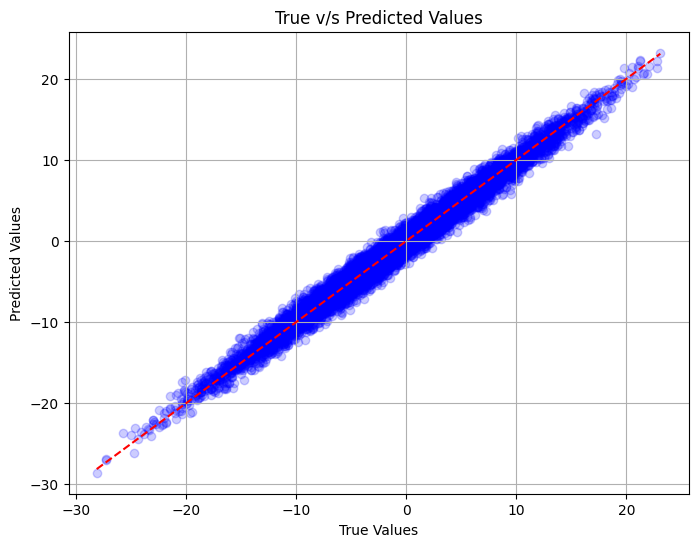

In [41]:
# Scatter plot of true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='blue', alpha=0.2)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.title('True v/s Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

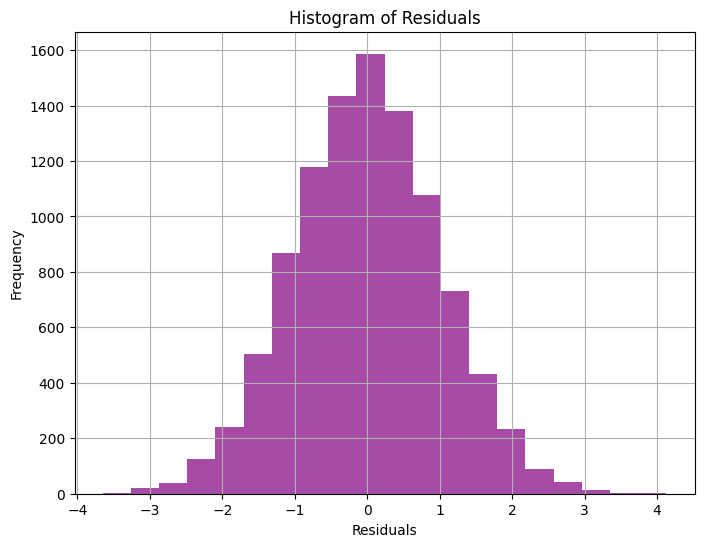

In [42]:
residuals = y_true - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='purple', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

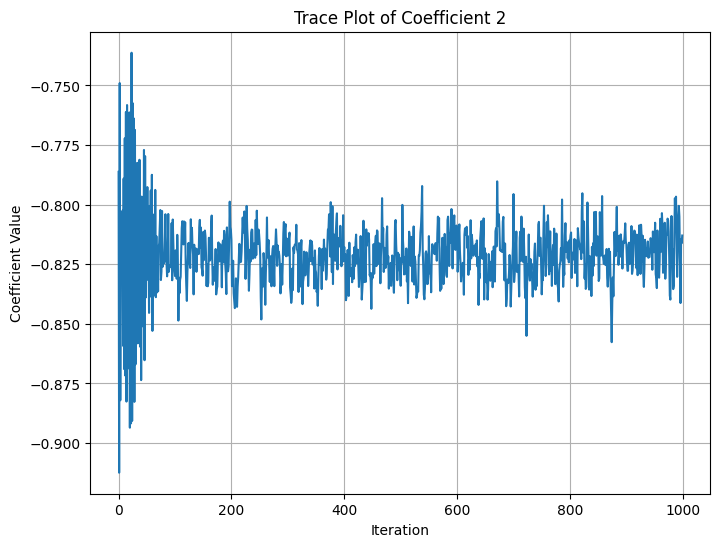

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(samples[:, 1])  # Plot trace of the second coefficient
plt.title('Trace Plot of Coefficient 2')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()

##Hyperparameter Tuning

In [ ]:
leapfrog_steps = [5, 10, 15]
target_acceptance_rates = [0.6, 0.7, 0.8]
adaptation_rates = [(0.01, 0.1, 0.6, 0.05), (0.005, 0.05, 0.5, 0.03)]  # (gamma, kappa, delta, eta)

best_performance = float('inf')
best_hyperparameters = None

for L in leapfrog_steps:
    for target_acceptance_rate in target_acceptance_rates:
        for adaptation_rate in adaptation_rates:
            blr = BayesianLinearRegression(X, y_true)
            blr.target_acceptance_rate = target_acceptance_rate
            blr.gamma, blr.kappa, blr.delta, blr.eta = adaptation_rate
            samples = blr.hamiltonian_monte_carlo(num_samples=5000, L=L)

#Comparison between Scikit-learn Linear Regression and HMC Regression for High-Dimensional Data

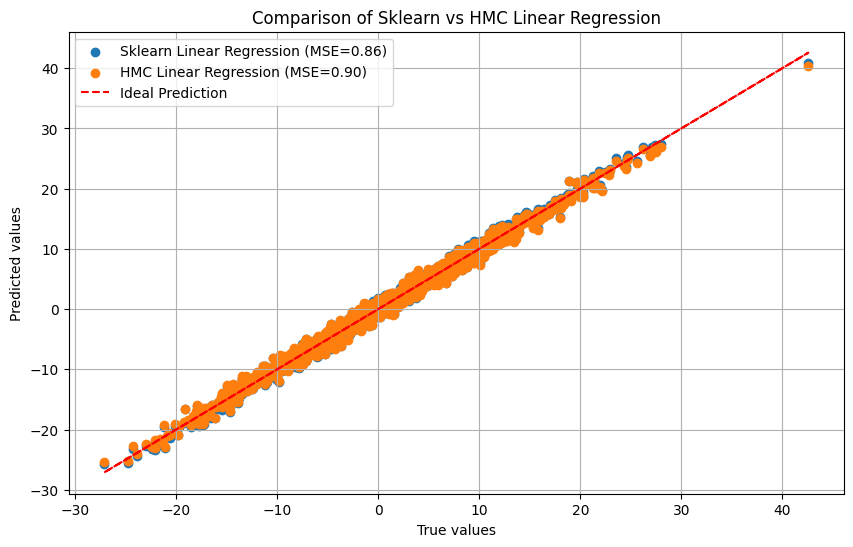

In [46]:
from sklearn.linear_model import LinearRegression

# Generate data
np.random.seed(42)
n = 1000  # Samples
d = 100    # Features
X = np.random.randn(n, d)
true_beta = np.random.randn(d + 1)
y_true = np.dot(np.hstack((np.ones((n, 1)), X)), true_beta) + np.random.randn(n)

# Linear regression using sklearn
reg_sklearn = LinearRegression()
reg_sklearn.fit(X, y_true)
y_pred_sklearn = reg_sklearn.predict(X)
mse_sklearn = np.mean((y_true - y_pred_sklearn) ** 2)

# Linear regression using HMC
bayesian_lr = BayesianLinearRegression(X, y_true)
samples = bayesian_lr.hamiltonian_monte_carlo(num_samples=1000, L=100)
y_pred_hmc = np.dot(np.hstack((np.ones((n, 1)), X)), samples.mean(axis=0))
mse_hmc = np.mean((y_true - y_pred_hmc) ** 2)

# Visualizing
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred_sklearn, label=f'Sklearn Linear Regression (MSE={mse_sklearn:.2f})')
plt.scatter(y_true, y_pred_hmc, label=f'HMC Linear Regression (MSE={mse_hmc:.2f})')
plt.plot(y_true, y_true, color='red', linestyle='--', label='Ideal Prediction')
plt.title('Comparison of Sklearn vs HMC Linear Regression')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()